In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
from sklearn.linear_model import Ridge
from tabulate import tabulate
import mlflow
from sklearn.linear_model import SGDRegressor
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous

path = 'datasets/LEAF_LEVEL_DATASET_Yufeng_Ge.xlsx'

# Read and load dataset
df= pd.read_excel(path, sheet_name=[0, 1])


/home/ubuntu/Desktop/Demetra/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INPUT DATA

In [2]:
X =df.get(0)
X = (X.iloc[:,14:]).values
print(X.shape)

(2905, 2151)


OUTPUT DATA

In [3]:
Y =df.get(0)
Y = (Y.iloc[:,7]).values
print(Y.shape)

(2905,)


RIDGE REGRESSION with closed form solution

2024/07/10 23:06:47 INFO mlflow.tracking.fluent: Experiment with name 'Ridge Cholesky NITROGEN' does not exist. Creating a new experiment.


0.05 ripartition
gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	10    	-0.115306	0.0112641  	-0.092216  	-0.130979  
1  	20    	-0.10895 	0.00882358 	-0.092216  	-0.125683  
2  	20    	-0.104959	0.00837682 	-0.092216  	-0.115651  
3  	20    	-0.0986561	0.00669682 	-0.092216  	-0.109535  
4  	20    	-0.0992456	0.00719086 	-0.092216  	-0.112027  
5  	20    	-0.0973615	0.00685614 	-0.092216  	-0.113095  
6  	20    	-0.0952736	0.00453234 	-0.092216  	-0.106897  
7  	20    	-0.0958723	0.00940719 	-0.0909767 	-0.123792  
8  	20    	-0.0949755	0.00954125 	-0.0909767 	-0.123514  
9  	20    	-0.0979911	0.0131596  	-0.0909165 	-0.124849  
10 	20    	-0.0982419	0.0114483  	-0.0909165 	-0.124849  
gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	10    	-0.120271	0.00899605 	-0.100593  	-0.133048  
1  	20    	-0.113631	0.00957394 	-0.0983727 	-0.123136  
2  	20    	-0.112964	0.00730629 	-0.100593  	-0.122873  
3  	20    	-0.10646 	0.00649684 	-0.100593  	-0.117145  
4  	20

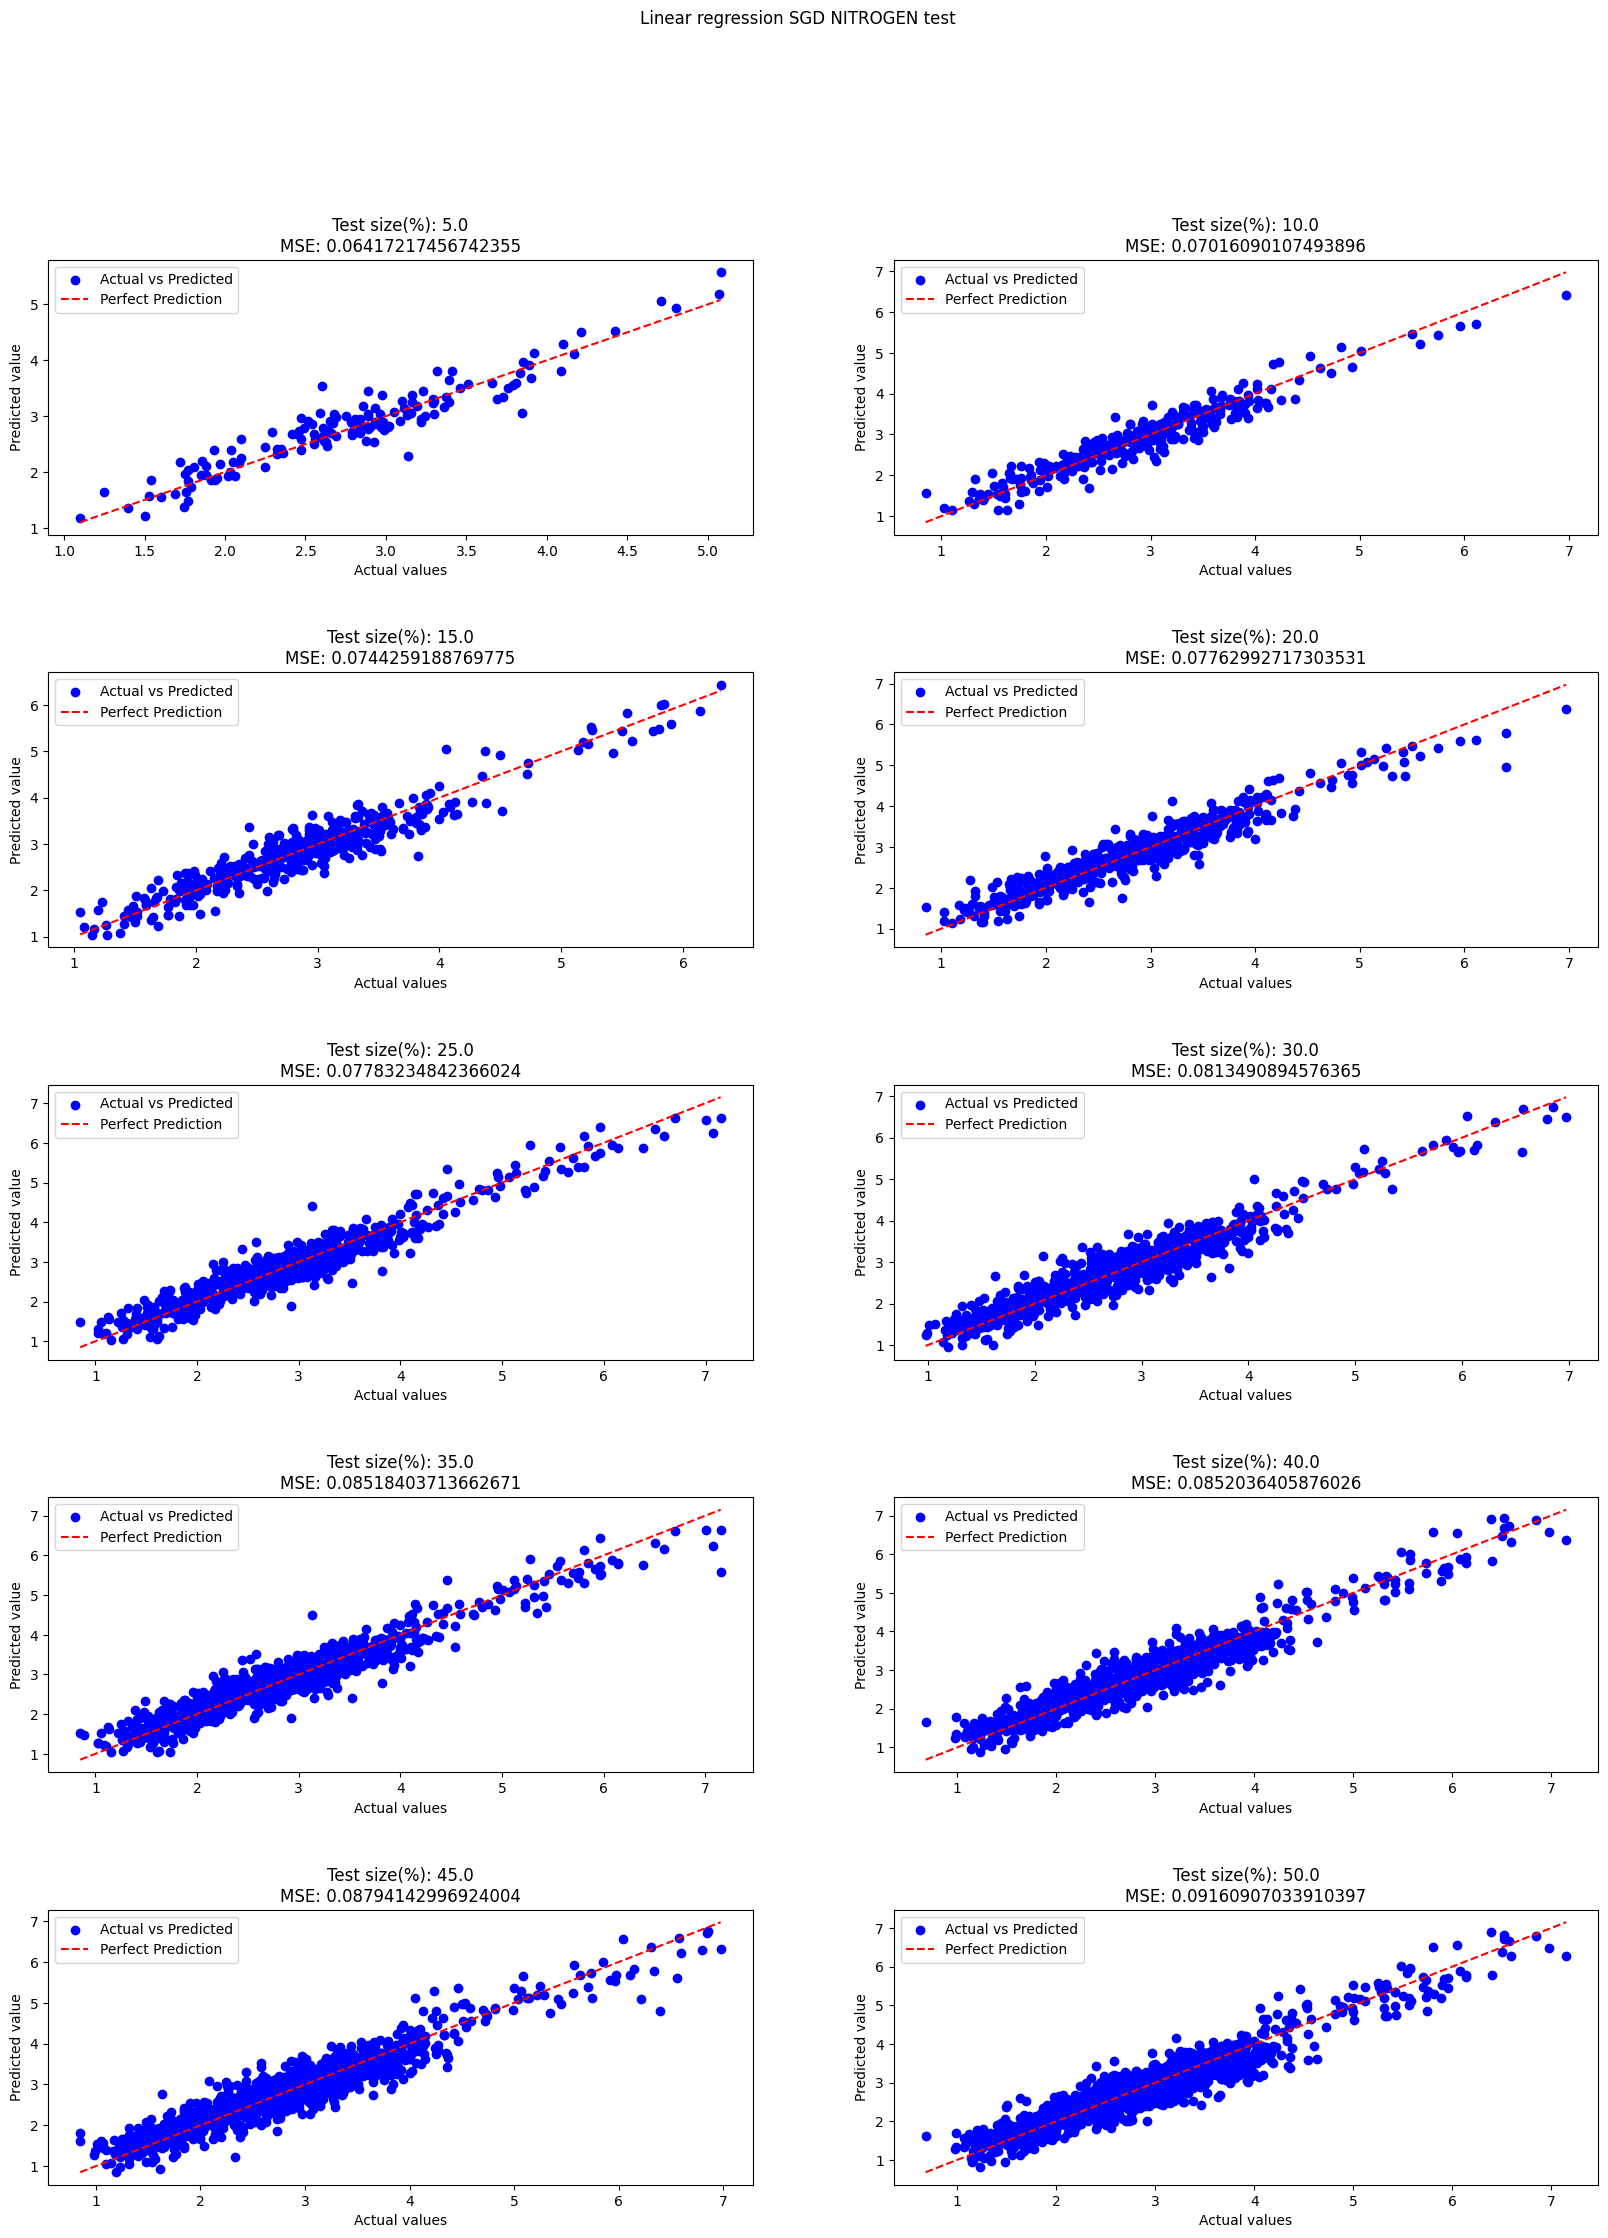

In [4]:
mlflow.set_experiment("Ridge Cholesky NITROGEN")
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
import sys, os

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [i/100 for i in range(5,55,5)]
results = []  
fig, axs = plt.subplots(5, 2,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle("Ridge Cholesky NITROGEN NRMSEPiqr"+"\n")
axs = axs.flatten()
# create 5x2 subfigs
fig, axs = plt.subplots(5, 2,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Ridge Cholesky NITROGEN test'+"\n")
axs = axs.flatten()
k = 0

for ripartition in ripartisions:

    '''PARAM 1'''

    MSE_param1 = []

    best_MSE_1 = 100000000
    best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}

    run_name = str(ripartition) + " ripartition"
    print(run_name)
    with mlflow.start_run(run_name=run_name):
        mlflow.log_param('ripartition', ripartition)
        i = 0
        for i in range(trials):
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            param_grid = {'alpha': Continuous(1/100000,0.01)}
            ridge_reg_cl = Ridge(solver="cholesky")
            
            evolved_estimator = GASearchCV(estimator=ridge_reg_cl,
                                  cv=5,
                                  scoring='neg_mean_squared_error',
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  verbose=True,
                                  population_size=10,
                                  generations=10)
    
            evolved_estimator.fit(X_train, Y_train)
    
            # Make predictions using the testing set
            Y_pred_ridge_cl =  evolved_estimator.predict(X_test)
    
            #save MSE of the first parameters
            MSE_param1.append(mean_squared_error(Y_test, Y_pred_ridge_cl))
    
            #check if this is the best model in terms of MSE
            if MSE_param1[-1] < best_MSE_1:
              best_MSE_1 = MSE_param1[-1]
              best_data_1["Y_test"] = Y_test
              best_data_1["Y_pred"] = Y_pred_ridge_cl
              best_data_1["alpha"] =  float(evolved_estimator.best_params_["alpha"])
              best_data_1["seed"] = seeds[i]
        
        mlflow.log_metric("Best_MSE", best_MSE_1)
        mlflow.log_metric("Mean_MSE", np.mean(MSE_param1))
        mlflow.log_metric("Var_MSE", np.var(MSE_param1))
        mlflow.log_metric("alpha", best_data_1["alpha"])
    


    results.append([str(ripartition *100 ), str(best_MSE_1),
                    (np.mean(MSE_param1)), str(np.var(MSE_param1)),
                    str(best_data_1["alpha"]),best_data_1["seed"]])

    '''PLOT THE BEST MODELS'''
    axs[k].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
    axs[k].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
    axs[k].legend()
    axs[k].set_xlabel("Actual values")
    axs[k].set_ylabel("Predicted value")
    axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "BEST MSE: " + str(min(MSE_param1)) )
    k += 1


'''SHOW RESULTS'''

headers = ["Test size(%)", "Best(MSE)", "Mean(MSE)", "Var(MSE)","Seed"]

print(tabulate(results, headers,  tablefmt="double_outline"))



**RIDGE REGRESSION with closed form solution NRMSEPiqr**

0.05 ripartition
Trial: 1
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.332027	0.0165693  	0.354399   	0.297116   
1  	20    	0.347706	0.00852116 	0.354399   	0.326332   
2  	20    	0.347626	0.00482527 	0.354399   	0.338608   
3  	20    	0.351084	0.00193924 	0.354399   	0.349474   
4  	20    	0.351428	0.00162982 	0.354399   	0.349686   
5  	20    	0.351246	0.00447942 	0.354399   	0.339715   
6  	20    	0.349615	0.00492321 	0.354399   	0.339238   
7  	20    	0.353814	0.000922994	0.354399   	0.351436   
8  	20    	0.353815	0.000920595	0.354399   	0.351436   
9  	20    	0.351256	0.00453208 	0.354399   	0.34327    
10 	20    	0.350439	0.00520472 	0.354399   	0.339349   
Trial: 2
gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	10    	0.34657	0.0182462  	0.365629   	0.313912   
1  	20    	0.36285	0.00456422 	0.366623   	0.355261   
2  	20    	0.365921	0.000616364	0.366623   	0.364487   
3  	20    	0.364011	0.00593566 	0.366623   	0.346219   
4  	20    	0.362

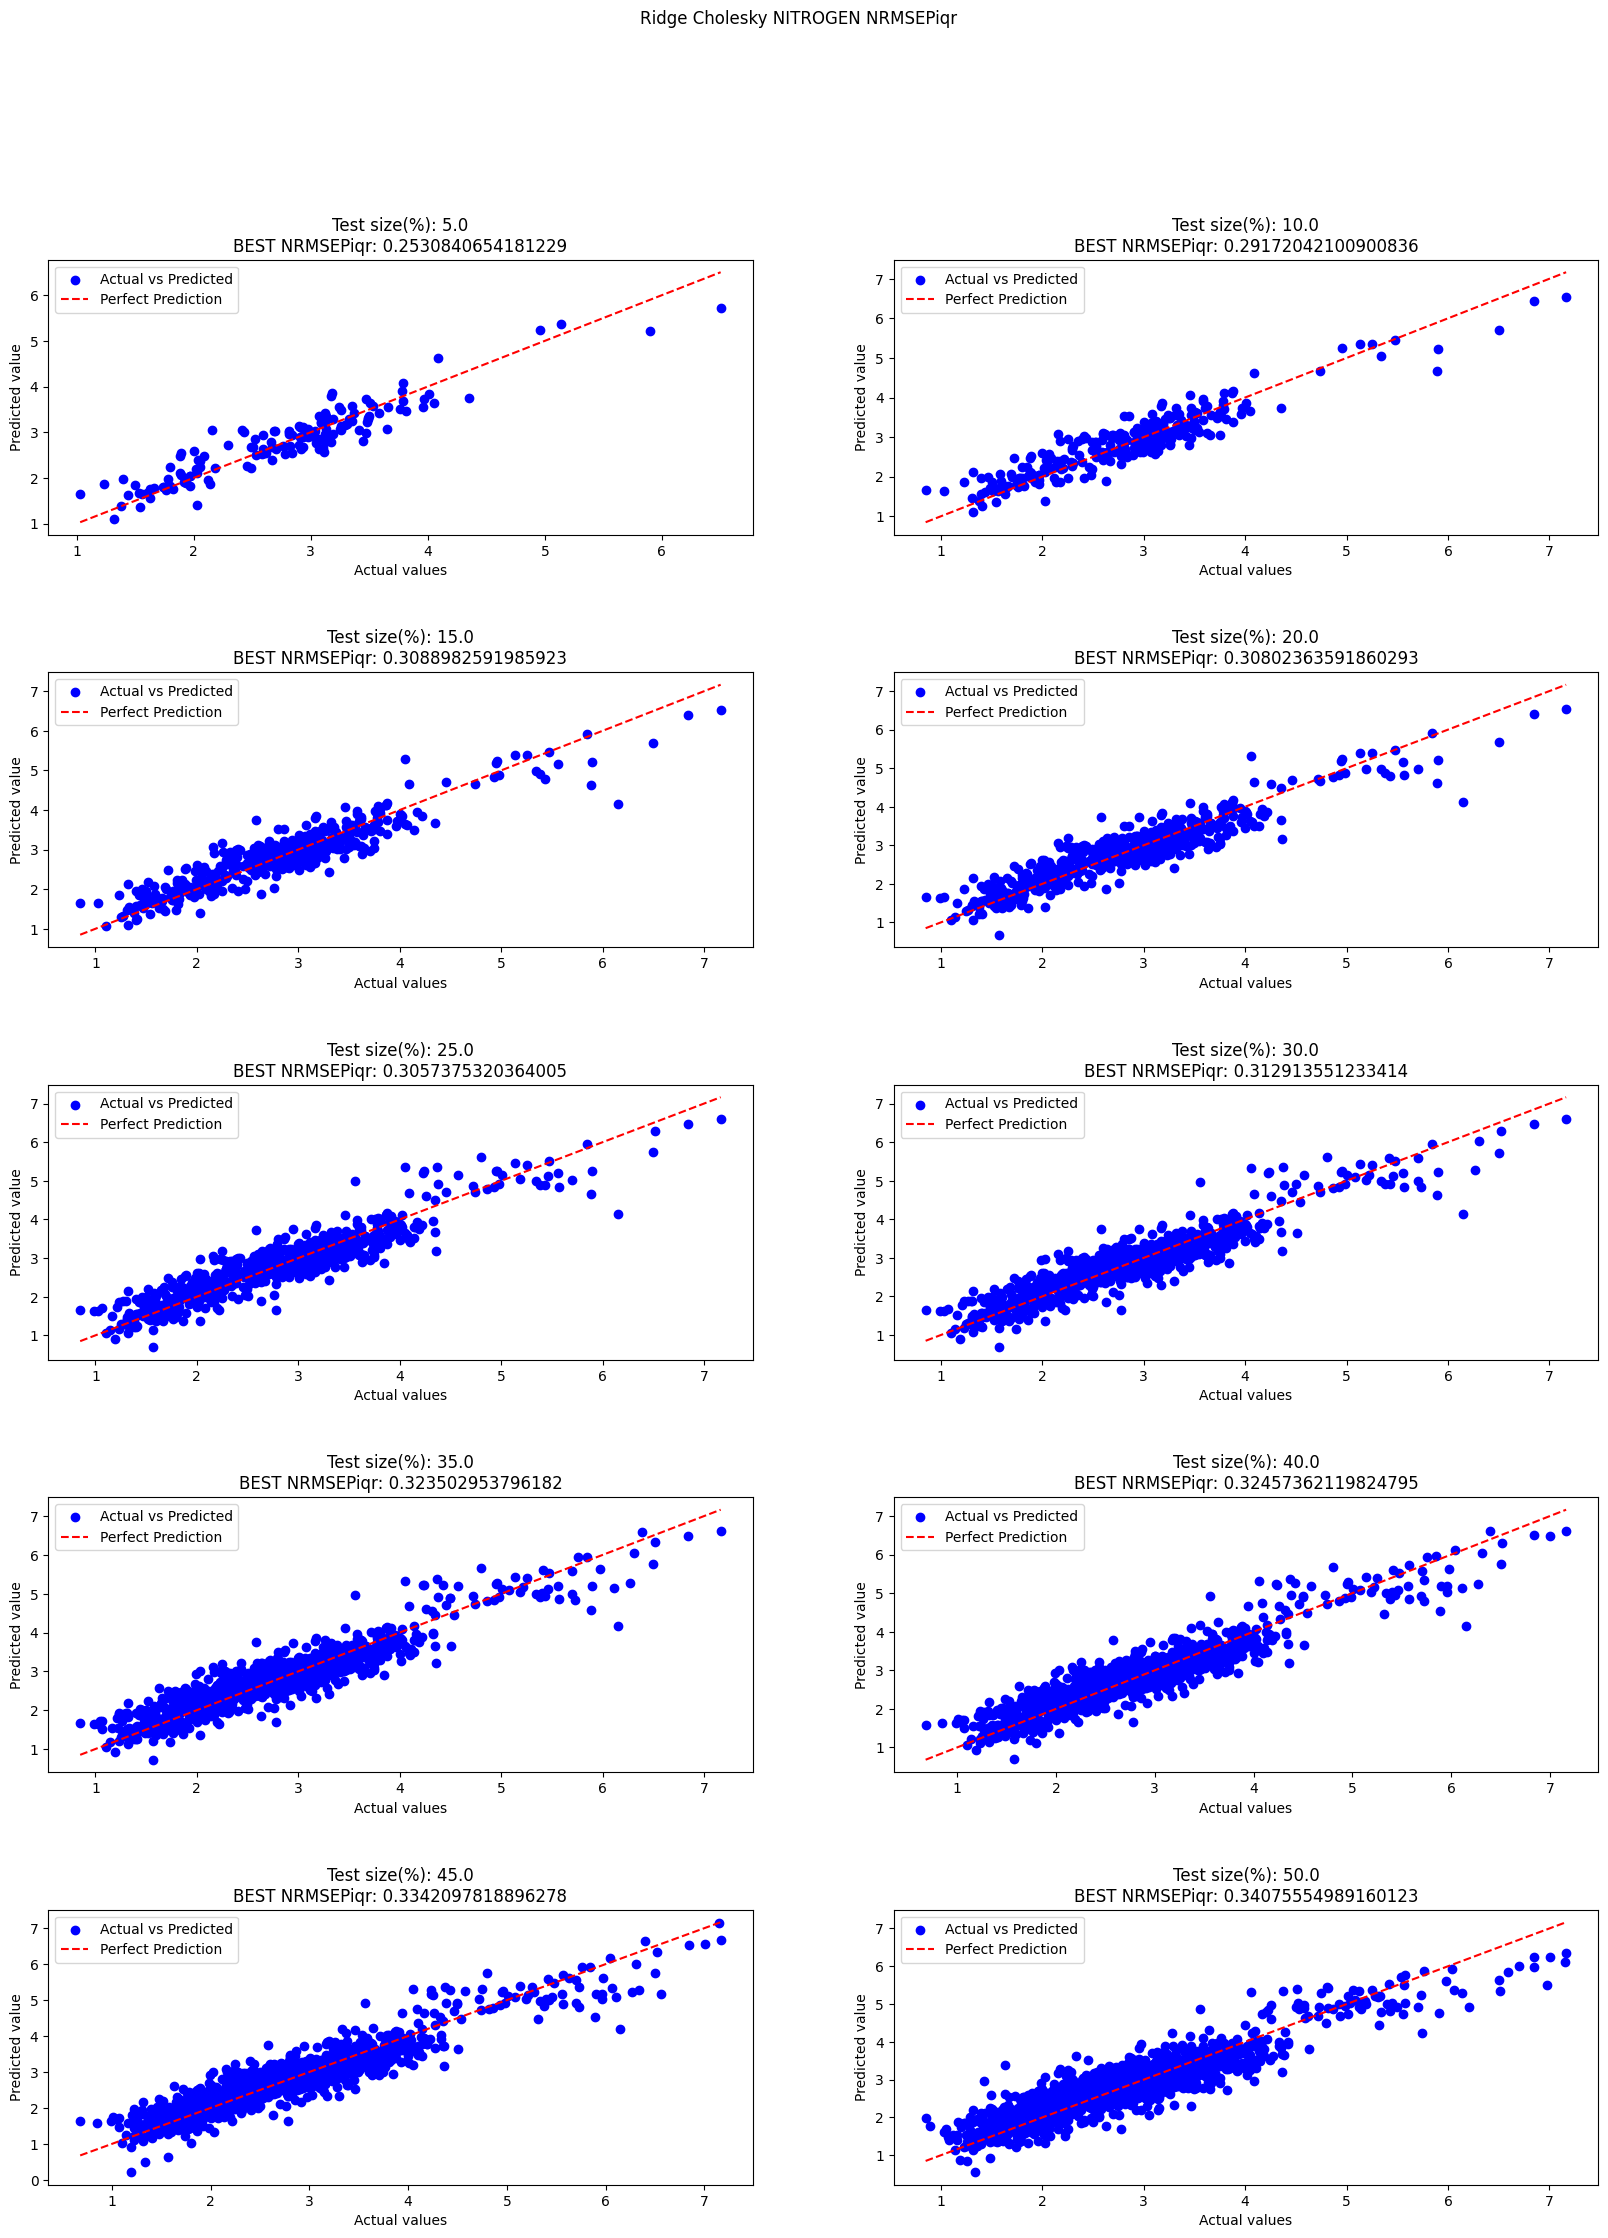

In [17]:
from sklearn.metrics import make_scorer

def NRMSEPiqr(observed_values, predicted_values):
    # Calculate RMSEP
    rmsep = np.sqrt(np.mean((observed_values - predicted_values) ** 2))
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(observed_values, 25)
    Q3 = np.percentile(observed_values, 75)

    # Calculate IQR
    IQR = Q3 - Q1

    return rmsep/IQR

NRMSEPiqrscorer = make_scorer(NRMSEPiqr)



mlflow.set_experiment("Ridge Cholesky NITROGEN NRMSEPiqr")
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
import sys, os

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [i/100 for i in range(5,55,5)]
results = []  

# create 5x2 subfigs
fig, axs = plt.subplots(5, 2,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle("Ridge Cholesky NITROGEN NRMSEPiqr"+"\n")
axs = axs.flatten()
k = 0

for ripartition in ripartisions:

    '''PARAM 1'''

    NRMSEP = []

    best_NRMSEP = 100000000
    best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}

    run_name = str(ripartition) + " ripartition"
    print(run_name)
    with mlflow.start_run(run_name=run_name):
        mlflow.log_param('ripartition', ripartition)
        for i in range(trials):
            print("Trial:",i+1)
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            param_grid = {'alpha': Continuous(1/100000,0.01)}
            ridge_reg_cl = Ridge(solver="cholesky")
            
            evolved_estimator = GASearchCV(estimator=ridge_reg_cl,
                                  cv=5,
                                  scoring=NRMSEPiqrscorer,
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  verbose=True,
                                  population_size=10,
                                  generations=10)
    
            evolved_estimator.fit(X_train, Y_train)
    
            # Make predictions using the testing set
            Y_pred_ridge_cl =  evolved_estimator.predict(X_test)
    
            #save NRMSEP of the first parameters
            NRMSEP.append(NRMSEPiqr(Y_test, Y_pred_ridge_cl))
    
            #check if this is the best model in terms of MSE
            if NRMSEP[-1] < best_NRMSEP:
              best_NRMSEP = NRMSEP[-1]
              best_data_1["Y_test"] = Y_test
              best_data_1["Y_pred"] = Y_pred_ridge_cl
              best_data_1["alpha"] =  float(evolved_estimator.best_params_["alpha"])
              best_data_1["seed"] = seeds[i]
        
        mlflow.log_metric("Best_NRMSEPiqr", best_NRMSEP)
        mlflow.log_metric("Mean_NRMSEPiqr", np.mean(NRMSEP))
        mlflow.log_metric("Var_NRMSEPiqr", np.var(NRMSEP))
        mlflow.log_metric("alpha", best_data_1["alpha"])
    


    results.append([str(ripartition *100 ), str(best_NRMSEP),
                    (np.mean(NRMSEP)), str(np.var(NRMSEP)),
                    str(best_data_1["alpha"]),best_data_1["seed"]])

    '''PLOT THE BEST MODELS'''
    axs[k].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
    axs[k].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
    axs[k].legend()
    axs[k].set_xlabel("Actual values")
    axs[k].set_ylabel("Predicted value")
    axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "BEST NRMSEPiqr: " + results[k][1] )
    k += 1


'''SHOW RESULTS'''

headers = ["Test size(%)", "Best(NRMSEPiqr)", "Mean(NRMSEPiqr)", "Var(NRMSEPiqr)","Seed"]

print(tabulate(results, headers,  tablefmt="double_outline"))



**RIDGE REGRESSION with SGD**

2024/07/12 06:35:24 INFO mlflow.tracking.fluent: Experiment with name 'Ridge SGD NITROGEN' does not exist. Creating a new experiment.


0.05 ripartition
gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	10    	-0.453006	0.0328222  	-0.40999   	-0.503038  
1  	20    	-0.434395	0.022536   	-0.414461  	-0.489464  
2  	20    	-0.438928	0.0221244  	-0.411966  	-0.468878  
3  	20    	-0.427411	0.0190899  	-0.411966  	-0.465969  
4  	20    	-0.420836	0.0145749  	-0.410098  	-0.461767  
5  	20    	-0.413654	0.0042453  	-0.410098  	-0.424733  
6  	20    	-0.411491	0.000885546	-0.410098  	-0.412387  
7  	20    	-0.419957	0.0201987  	-0.410098  	-0.480022  
8  	20    	-0.413293	0.00368554 	-0.410098  	-0.422204  
9  	20    	-0.412639	0.00284391 	-0.410098  	-0.418406  
10 	20    	-0.419212	0.0187085  	-0.410098  	-0.473346  
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	-0.45361	0.0221974  	-0.424108  	-0.478605  
1  	20    	-0.439333	0.00971067 	-0.433146  	-0.465004  
2  	20    	-0.435996	0.00485514 	-0.43138   	-0.445382  
3  	20    	-0.431482	0.00363398 	-0.425272  	-0.435808  
4  	20    	-0.43

KeyboardInterrupt: 

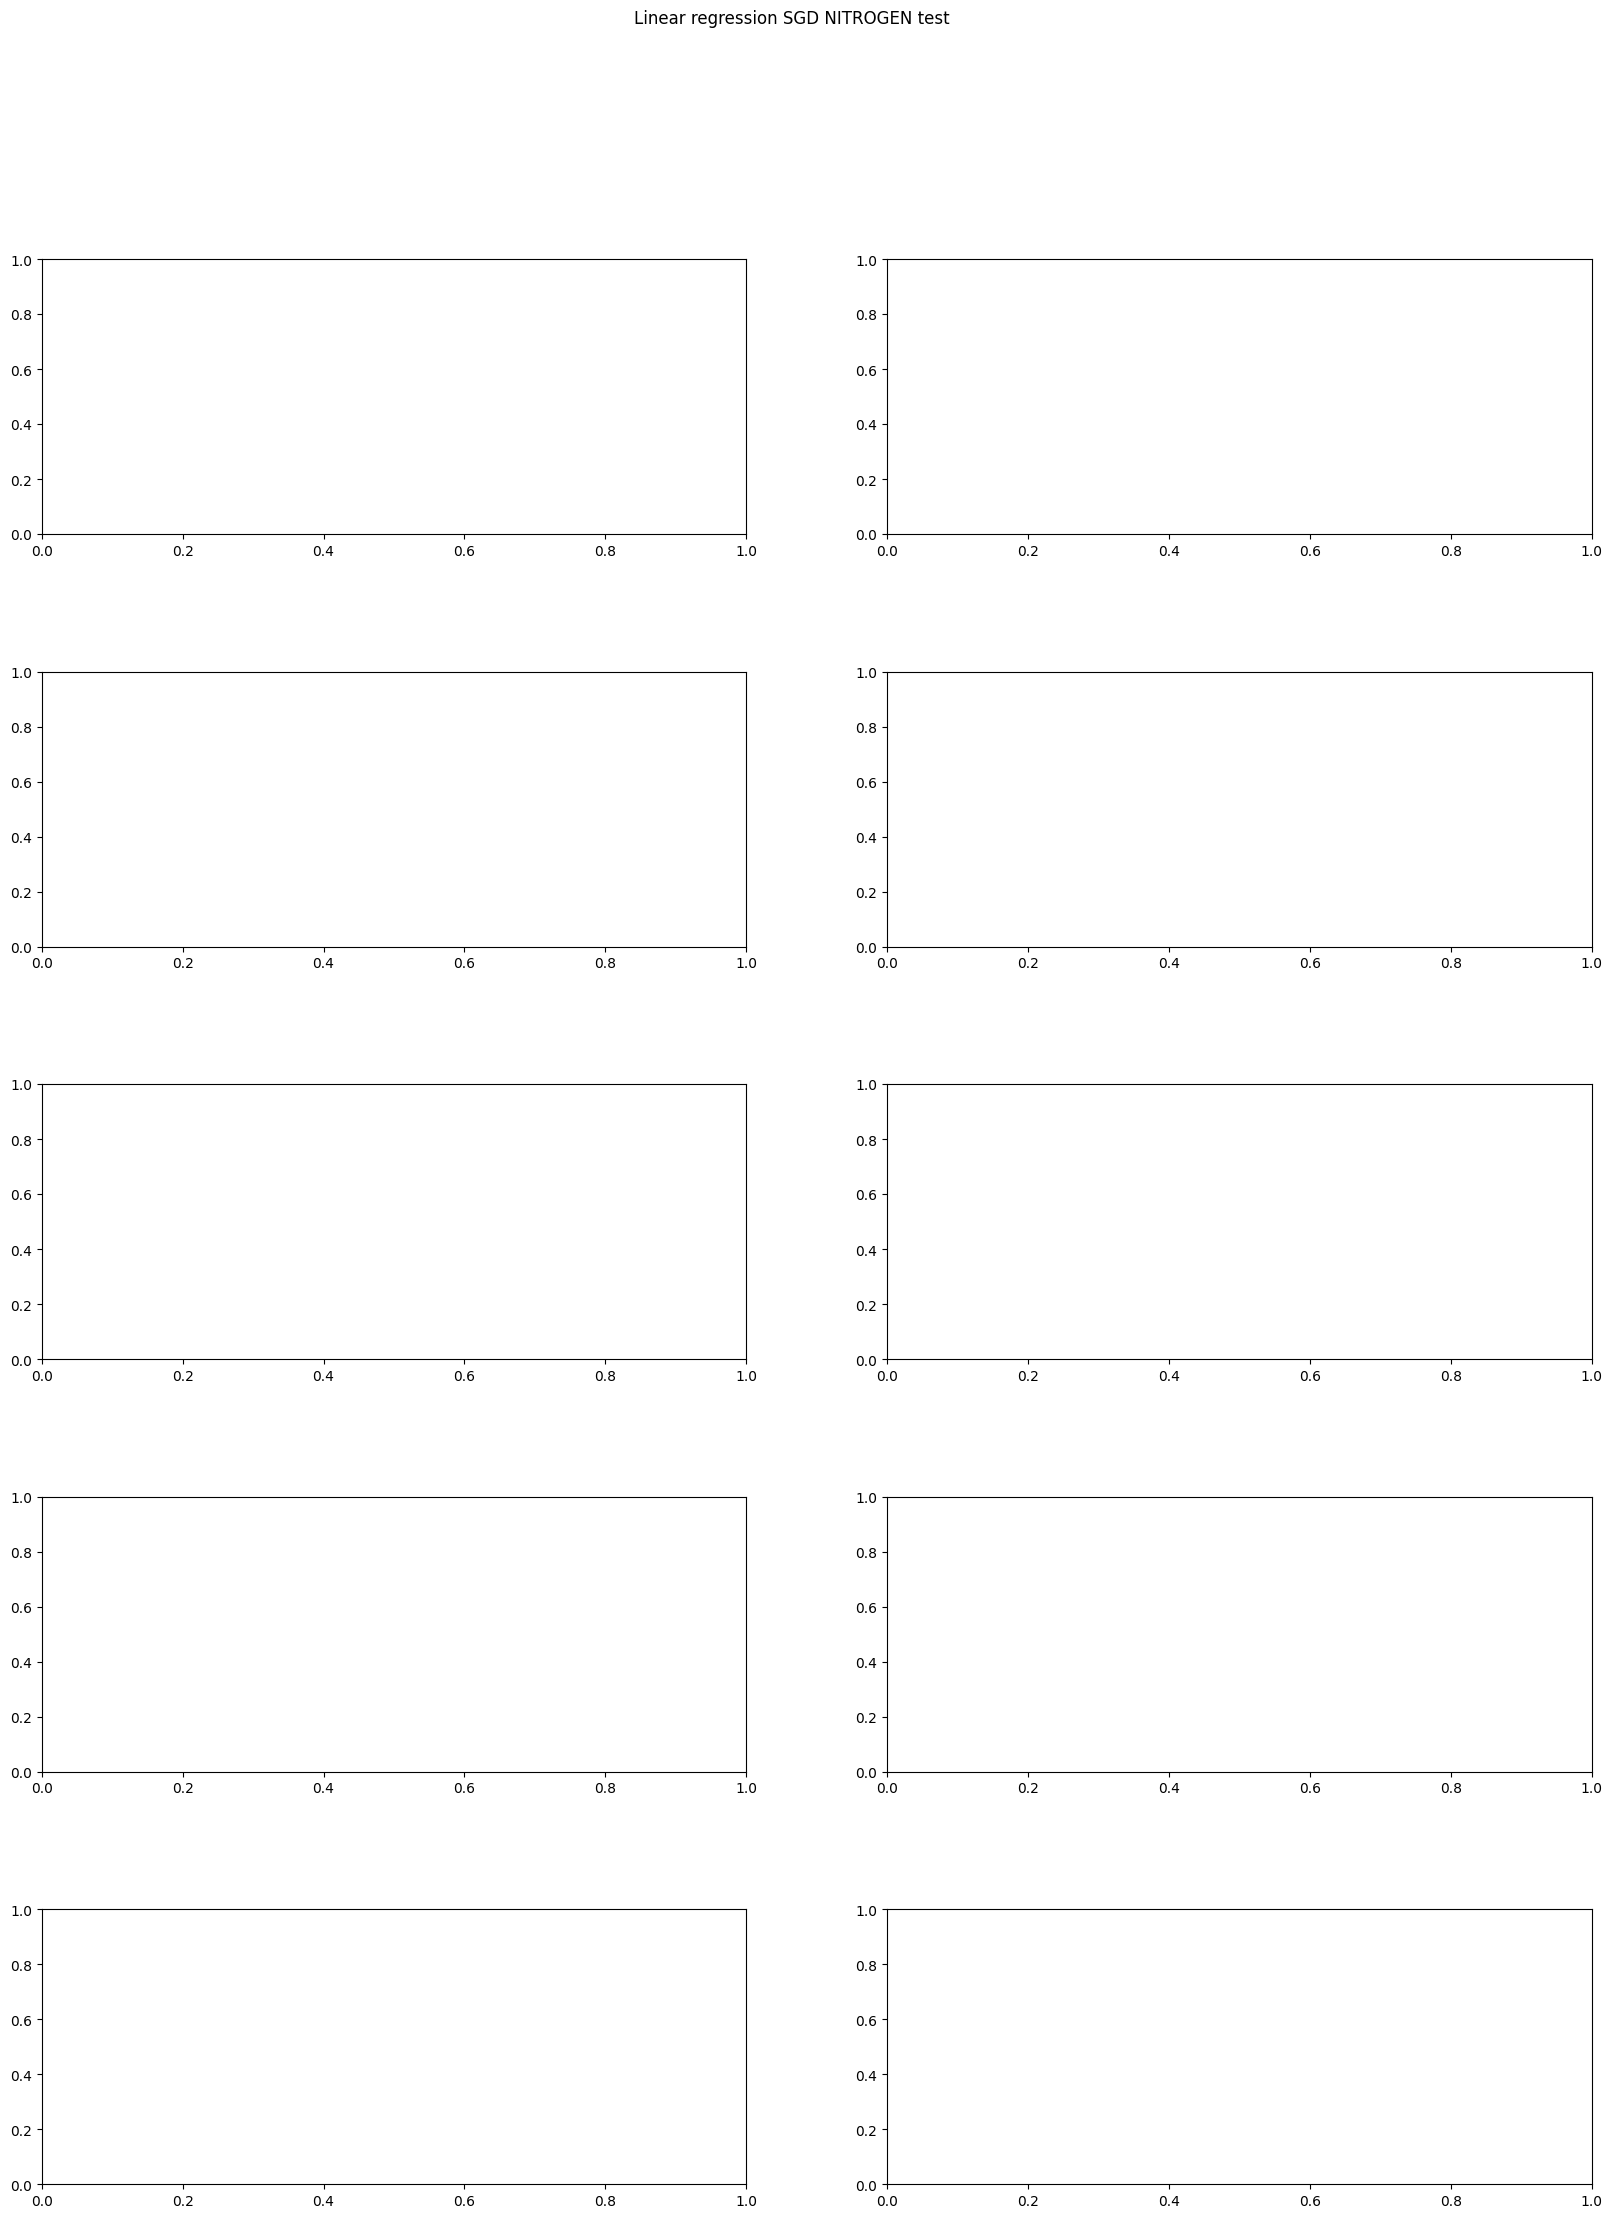

In [5]:
mlflow.set_experiment("Ridge SGD NITROGEN")
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
from sklearn.linear_model import SGDRegressor
import sys, os

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [i/100 for i in range(5,55,5)]
results = [] 

# create 5x2 subfigs
fig, axs = plt.subplots(5, 2,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Linear regression SGD NITROGEN test'+"\n")
axs = axs.flatten()
k = 0

for ripartition in ripartisions:

    '''PARAM 1'''

    MSE_param1 = []

    best_MSE_1 = 100000000
    best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}

    run_name = str(ripartition) + " ripartition"
    print(run_name)
    with mlflow.start_run(run_name=run_name):
        mlflow.log_param('ripartition', ripartition)
        i = 0
        for i in range(trials):
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            param_grid = {'alpha': Continuous(1/100000,0.01)}
            ridge_reg_sgd = SGDRegressor(max_iter=5000, tol=1e-5, penalty="l2", eta0=0.01,
                                                n_iter_no_change=10, random_state=42)
    
            evolved_estimator = GASearchCV(estimator=ridge_reg_sgd,
                                  cv=5,
                                  scoring=NRMSEPiqrscorer,
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  verbose=True,
                                  population_size=10,
                                  generations=10)
    
            evolved_estimator.fit(X_train, Y_train)
    
            # Make predictions using the testing set
            Y_pred_ridge_sgd =  evolved_estimator.predict(X_test)
    
            #save MSE of the first parameters
            MSE_param1.append(mean_squared_error(Y_test, Y_pred_ridge_sgd))
    
            #check if this is the best model in terms of MSE
            if MSE_param1[-1] < best_MSE_1:
              best_MSE_1 = MSE_param1[-1]
              best_data_1["Y_test"] = Y_test
              best_data_1["Y_pred"] = Y_pred_ridge_sgd
              best_data_1["alpha"] =  float(evolved_estimator.best_params_["alpha"])
              best_data_1["seed"] = seeds[i]


    results.append([str(ripartition *100 ), str(best_MSE_1),
     (np.mean(MSE_param1)), str(np.var(MSE_param1)), 
        str(best_data_1["alpha"]),str(best_data_2["alpha"]),
                    best_data_1["seed"],best_data_2["seed"]])

    '''PLOT THE BEST MODELS'''
    axs[k].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
    axs[k].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
    axs[k].set_title("Best MSE results" + "\n" + f"Test size(%): {ripartition * 100}")
    axs[k].legend()
    axs[k].set_xlabel("Actual values")
    axs[k].set_ylabel("Predicted value")
    axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "MSE: " + str(min(MSE_param1)) )
    k += 1


'''SHOW RESULTS'''

headers = ["Test size(%)", "Best(MSE)", "Mean(MSE)", "Var(MSE)","Seed"]

print(tabulate(results, headers,  tablefmt="double_outline"))



**RIDGE REGRESSION with SGD NRMSEPiqr**

In [ ]:
mlflow.set_experiment("Ridge SGD NITROGEN NRMSEPiqr")
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
from sklearn.linear_model import SGDRegressor
import sys, os

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 


def NRMSEPiqr(observed_values, predicted_values):
    # Calculate RMSEP
    rmsep = np.sqrt(np.mean((observed_values - predicted_values) ** 2))
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(observed_values, 25)
    Q3 = np.percentile(observed_values, 75)

    # Calculate IQR
    IQR = Q3 - Q1

    return rmsep/IQR

NRMSEPiqrscorer = make_scorer(NRMSEPiqr)


#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [0.25, 0.5, 0.75]
results = [] 

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Ridge regression SGD NITROGEN NRMSEPiqr test'+"\n")
axs = axs.flatten()
k = 0

for ripartition in ripartisions:

    '''PARAM 1'''

    MSE_param1 = []

    best_MSE_1 = 100000000
    best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}

    run_name = str(ripartition) + " ripartition"
    print(run_name)
    with mlflow.start_run(run_name=run_name):
        mlflow.log_param('ripartition', ripartition)
        i = 0
        for i in range(trials):
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            param_grid = {'alpha': Continuous(1/100000,0.01)}
            ridge_reg_sgd = SGDRegressor(max_iter=5000, tol=1e-5, penalty="l2", eta0=0.01,
                                                n_iter_no_change=10, random_state=42)
    
            evolved_estimator = GASearchCV(estimator=ridge_reg_sgd,
                                  cv=5,
                                  scoring=NRMSEPiqrscorer,
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  verbose=True,
                                  population_size=10,
                                  generations=10)
    
            evolved_estimator.fit(X_train, Y_train)
    
            # Make predictions using the testing set
            Y_pred_ridge_sgd =  evolved_estimator.predict(X_test)
    
            #save MSE of the first parameters
            MSE_param1.append(NRMSEPiqr(Y_test, Y_pred_ridge_sgd))
    
            #check if this is the best model in terms of MSE
            if MSE_param1[-1] < best_MSE_1:
              best_MSE_1 = MSE_param1[-1]
              best_data_1["Y_test"] = Y_test
              best_data_1["Y_pred"] = Y_pred_ridge_sgd
              best_data_1["alpha"] =  float(evolved_estimator.best_params_["alpha"])
              best_data_1["seed"] = seeds[i]


    results.append([str(ripartition *100 ), str(best_NRMSEP),
                    (np.mean(NRMSEP)), str(np.var(NRMSEP)),
                    str(best_data_1["alpha"]),best_data_1["seed"]])

    '''PLOT THE BEST MODELS'''
    axs[k].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
    axs[k].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
    axs[k].legend()
    axs[k].set_xlabel("Actual values")
    axs[k].set_ylabel("Predicted value")
    axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "BEST NRMSEPiqr: " + results[k][1] )
    k += 1


'''SHOW RESULTS'''

headers = ["Test size(%)", "Best(NRMSEPiqr)", "Mean(NRMSEPiqr)", "Var(NRMSEPiqr)","Seed"]

print(tabulate(results, headers,  tablefmt="double_outline"))


